In [2]:
# Cell 1: Import necessary libraries
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import  ModelCheckpoint
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from keras.applications import EfficientNetV2B3

In [3]:
# Cell 2: Define constants
BATCH_SIZE = 16
IMG_HEIGHT = 300 
IMG_WIDTH = 300
DATA_DIR = "/home/anon/MajorProject/Data/final_asl_mix"

In [5]:
# Cell 3: Load data

#train and test if already separated
# TRAIN_DATA_DIR = "/home/anon/MajorProject/Data/ASL_MAIN/asl_alphabet_train"
# TEST_DATA_DIR = "/home/anon/MajorProject/Data/Synthetic_Dataset/test"

# train_ds = tf.keras.utils.image_dataset_from_directory(
#     TRAIN_DATA_DIR,
#     image_size=(IMG_HEIGHT, IMG_WIDTH),
#     batch_size=BATCH_SIZE)

# val_ds = tf.keras.utils.image_dataset_from_directory(
#     TEST_DATA_DIR,
#     image_size=(IMG_HEIGHT, IMG_WIDTH),
#     batch_size=BATCH_SIZE)


train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

Found 95070 files belonging to 23 classes.
Using 76056 files for training.
Found 95070 files belonging to 23 classes.
Using 19014 files for validation.
['3', '5', 'A', 'B', 'Blank', 'C', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'O', 'P', 'Q', 'R', 'S', 'V', 'X', 'Y', 'space']


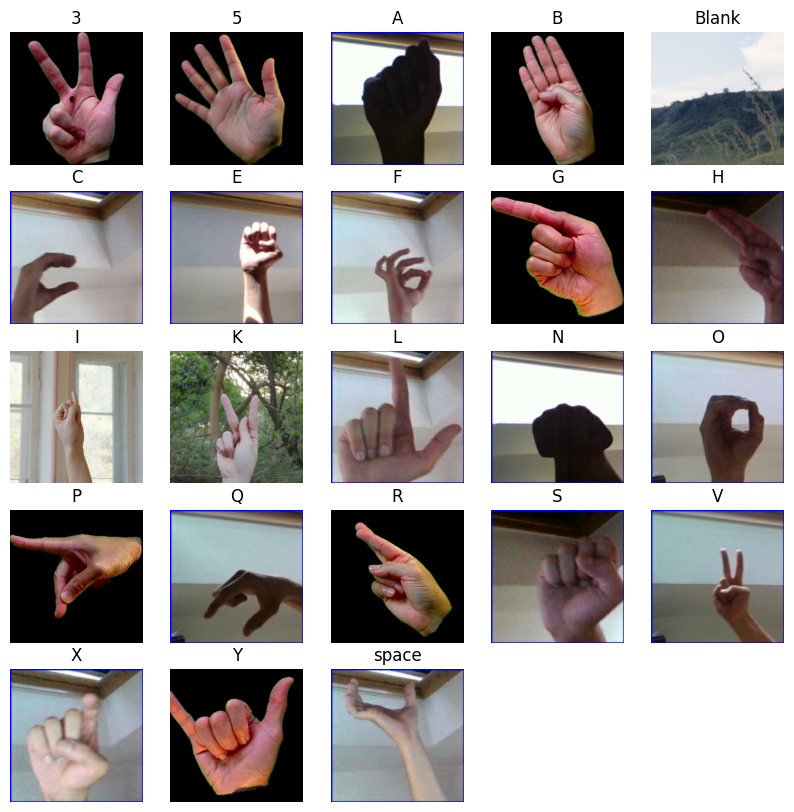

In [6]:
import math

# Calculate the number of rows and columns for the grid
num_rows = math.ceil(math.sqrt(num_classes))
num_cols = num_rows

plt.figure(figsize=(10, 10))

# Create a dictionary to store an image from each class
class_images = {class_name: None for class_name in class_names}

# Iterate over the batches
for images, labels in train_ds:
  # Iterate over the images and labels in the current batch
  for image, label in zip(images, labels):
    # If we haven't stored an image for this class yet, store it
    if class_images[class_names[label]] is None:
      class_images[class_names[label]] = image

  # If we've stored an image for each class, stop iterating over the batches
  if all(image is not None for image in class_images.values()):
    break

# Plot an image for each class
for i, class_name in enumerate(class_names):
  ax = plt.subplot(num_rows, num_cols, i + 1)
  plt.imshow(class_images[class_name].numpy().astype("uint8"))
  plt.title(class_name)
  plt.axis("off")



In [7]:
# Before data augmentation
for images, labels in train_ds.take(1):
  for image in images:
    print(image.shape)


(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)


In [8]:
# Cell 4: Define data augmentation
data_augmentation = keras.Sequential(
    [
        # layers.RandomFlip("horizontal"),
        # layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
        layers.RandomBrightness(0.1),
        # layers.RandomWidth(0.1),
        layers.RandomCrop(IMG_HEIGHT, IMG_HEIGHT),
    ]
)

In [9]:
# Cell 5: Preprocess data #data augmentation and one hot encoding
# train_ds = train_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), tf.one_hot(y, num_classes)))
# val_ds = val_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), tf.one_hot(y, num_classes)))


#no one hot encoding since class > 10:
# data augmentation
train_ds = train_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), y))
val_ds = val_ds.map(lambda x, y: (x, y))

In [10]:
# After data augmentation
for images, labels in train_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), y)).take(1):
    for image in images:
        print(image.shape)

(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)


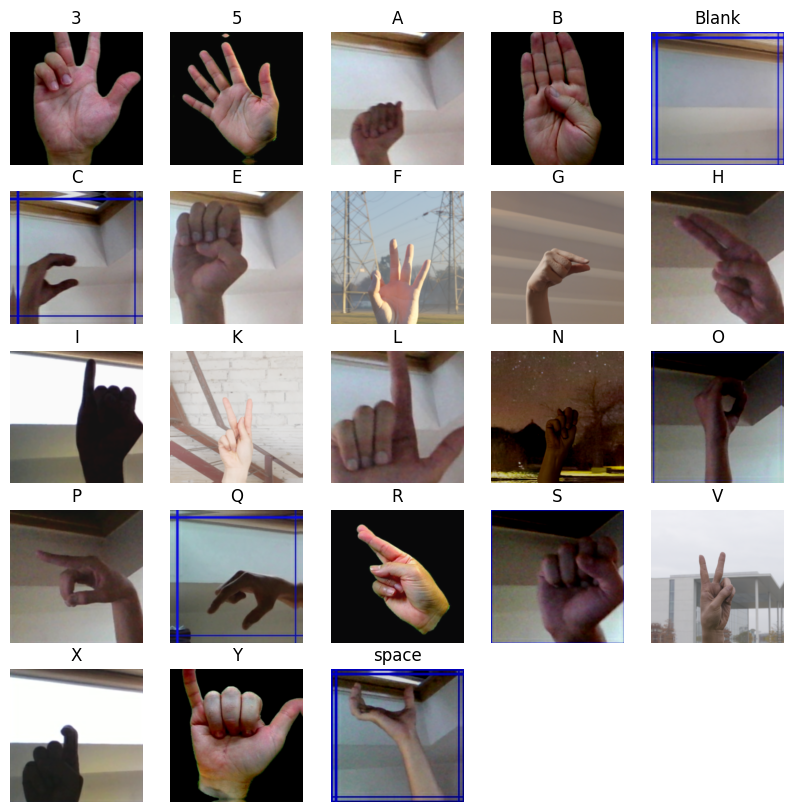

In [11]:
import math

# Calculate the number of rows and columns for the grid
num_rows = math.ceil(math.sqrt(num_classes))
num_cols = num_rows

plt.figure(figsize=(10, 10))

# Create a dictionary to store an image from each class
class_images = {class_name: None for class_name in class_names}

# Iterate over the batches
for images, labels in train_ds:
  # Apply data augmentation
  augmented_images = tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), images)
  
  # Iterate over the images and labels in the current batch
  for image, label in zip(augmented_images, labels):
    # If we haven't stored an image for this class yet, store it
    if class_images[class_names[label]] is None:
      class_images[class_names[label]] = image

  # If we've stored an image for each class, stop iterating over the batches
  if all(image is not None for image in class_images.values()):
    break

# Plot an image for each class
for i, class_name in enumerate(class_names):
  ax = plt.subplot(num_rows, num_cols, i + 1)
  plt.imshow(class_images[class_name].numpy().astype("uint8"))
  plt.title(class_name)
  plt.axis("off")


In [12]:
# Cell 6: Build model
inputs = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
model = EfficientNetV2B3(include_top=False, input_tensor=inputs, weights="imagenet")

# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.5
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(num_classes, activation="softmax", name="pred", kernel_regularizer=regularizers.l2(0.01))(x)  # L2 regularization
# outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)  # Removed L2 regularization

# Compile
model = keras.Model(inputs, outputs, name="EfficientNet")
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4, decay_steps=10000, decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy","SparseCategoricalAccuracy", "SparseTopKCategoricalAccuracy"])

In [13]:
for images, labels in train_ds.take(1):
    print(f'Training images shape: {images.shape}, labels shape: {labels.shape}')

for images, labels in val_ds.take(1):
    print(f'Validation images shape: {images.shape}, labels shape: {labels.shape}')


Training images shape: (16, 300, 300, 3), labels shape: (16,)
Validation images shape: (16, 300, 300, 3), labels shape: (16,)


In [14]:
print(model.summary())

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 300, 300, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 300, 300, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 150, 150, 40)         1080      ['normalization[0][

In [16]:
# Cell 7: Define callbacks
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint_filepath = '/home/anon/MajorProject/Non_Git/Checkpoints/final/checkpoint-{epoch:02d}-{val_accuracy:.4f}.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True)

In [17]:
#Cell 8 train the model
epochs = 30
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping, model_checkpoint,reduce_lr])

Epoch 1/30


2024-02-21 12:36:20.077621: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


   1/4754 [..............................] - ETA: 10:59:30 - loss: 5.6575 - accuracy: 0.0625 - sparse_categorical_accuracy: 0.0625 - sparse_top_k_categorical_accuracy: 0.2500

2024-02-21 12:36:21.542922: I external/local_xla/xla/service/service.cc:168] XLA service 0xaa6cdc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-21 12:36:21.542947: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-02-21 12:36:21.551652: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708498281.600014    1503 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4754/4754 [==============================] - ETA: 0s - loss: 2.3414 - accuracy: 0.4523 - sparse_categorical_accuracy: 0.4523 - sparse_top_k_categorical_accuracy: 0.7660

/home/anon/miniconda3/envs/major_tf/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4754/4754 [==============================] - 159s 32ms/step - loss: 2.3414 - accuracy: 0.4523 - sparse_categorical_accuracy: 0.4523 - sparse_top_k_categorical_accuracy: 0.7660 - val_loss: 0.9258 - val_accuracy: 0.8515 - val_sparse_categorical_accuracy: 0.8515 - val_sparse_top_k_categorical_accuracy: 0.9737 - lr: 9.5116e-05
Epoch 2/30
4754/4754 [==============================] - 149s 31ms/step - loss: 1.3249 - accuracy: 0.6830 - sparse_categorical_accuracy: 0.6830 - sparse_top_k_categorical_accuracy: 0.9289 - val_loss: 0.6870 - val_accuracy: 0.9012 - val_sparse_categorical_accuracy: 0.9012 - val_sparse_top_k_categorical_accuracy: 0.9869 - lr: 9.0469e-05
Epoch 3/30
4754/4754 [==============================] - 149s 31ms/step - loss: 1.1042 - accuracy: 0.7380 - sparse_categorical_accuracy: 0.7380 - sparse_top_k_categorical_accuracy: 0.9507 - val_loss: 0.6051 - val_accuracy: 0.9161 - val_sparse_categorical_accuracy: 0.9161 - val_sparse_top_k_categorical_accuracy: 0.9897 - lr: 8.6049e-05
Epo

In [18]:
# Cell 10: Save the model
model.save('/home/anon/MajorProject/Non_Git/Models/EfficientNetV2B3_300x300_final_asl_mix_FEB_21_has_3_K_REMOVED_W_batch_size_16.h5')
['3', '5', 'A', 'B', 'Blank', 'C', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'O', 'P', 'Q', 'R', 'S', 'V', 'X', 'Y', 'space']


['3',
 '5',
 'A',
 'B',
 'Blank',
 'C',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'V',
 'X',
 'Y',
 'space']

In [19]:
#for categorical_crossentropy
# import numpy as np

# # Initialize lists to store the true and predicted labels
# y_true = []
# y_pred = []

# # Iterate over the validation dataset
# for images, labels in val_ds:
#     # Get the model's predictions
#     pred_probs = model.predict(images)

#     # Convert the predicted probabilities to class labels
#     preds = np.argmax(pred_probs, axis=1)

#     # Convert one-hot encoded labels back to class labels
#     labels = np.argmax(labels.numpy(), axis=1)

#     # Append the labels to the lists
#     y_true.extend(labels)
#     y_pred.extend(preds)

# # Convert the lists to numpy arrays
# y_true = np.array(y_true)
# y_pred = np.array(y_pred)


#for sparse_categorical_crossentropy
import numpy as np

# Initialize lists to store the true and predicted labels
y_true = []
y_pred = []

# Iterate over the validation dataset
for images, labels in val_ds:
    # Get the model's predictions
    pred_probs = model.predict(images)

    # Convert the predicted probabilities to class labels
    preds = np.argmax(pred_probs, axis=1)

    # Append the labels to the lists
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Convert the lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 [==============================] - 0s 16ms/step


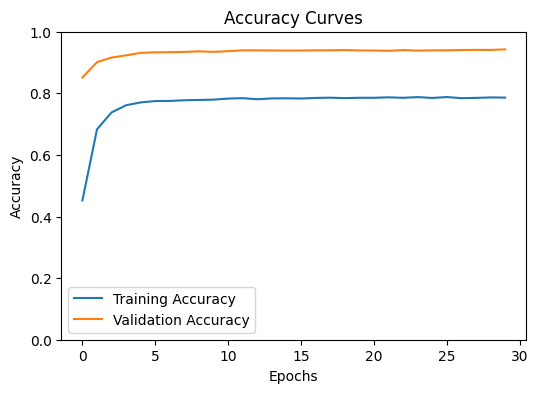

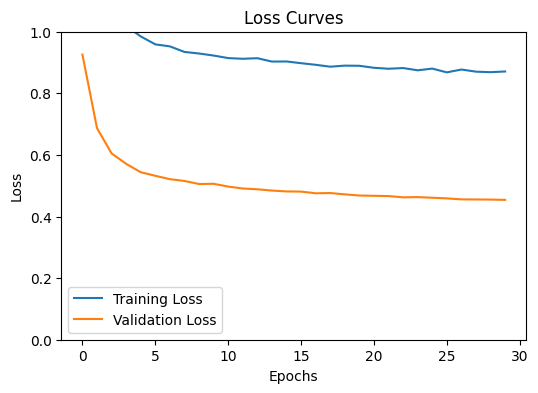

In [20]:
import matplotlib.pyplot as plt

# Plotting the Accuracy Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['accuracy'], linewidth=1.5)
plt.plot(hist.history['val_accuracy'], linewidth=1.5)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()

# Plotting the Loss Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['loss'], linewidth=1.5)
plt.plot(hist.history['val_loss'], linewidth=1.5)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()


Class: 3
Precision: 0.9530201342281879
Recall: 1.0
F1 Score: 0.9759450171821306
AUC-ROC: 0.9998145400593471

Class: 5
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
AUC-ROC: 1.0

Class: A
Precision: 0.9521739130434783
Recall: 0.926984126984127
F1 Score: 0.9394101876675603
AUC-ROC: 0.9622745085637332

Class: B
Precision: 0.9619047619047619
Recall: 0.9774193548387097
F1 Score: 0.9696
AUC-ROC: 0.9877143224094013

Class: Blank
Precision: 0.9875156054931336
Recall: 1.0
F1 Score: 0.9937185929648241
AUC-ROC: 0.9997256214673763

Class: C
Precision: 0.9654403567447045
Recall: 0.9600886917960089
F1 Score: 0.962757087270706
AUC-ROC: 0.9791885596789232

Class: E
Precision: 0.9381551362683438
Recall: 0.9322916666666666
F1 Score: 0.93521421107628
AUC-ROC: 0.9645118464052287

Class: F
Precision: 0.9602272727272727
Recall: 0.9451901565995525
F1 Score: 0.9526493799323562
AUC-ROC: 0.9716292946353172

Class: G
Precision: 0.9490291262135923
Recall: 0.8967889908256881
F1 Score: 0.9221698113207547
AUC-ROC: 0.9472

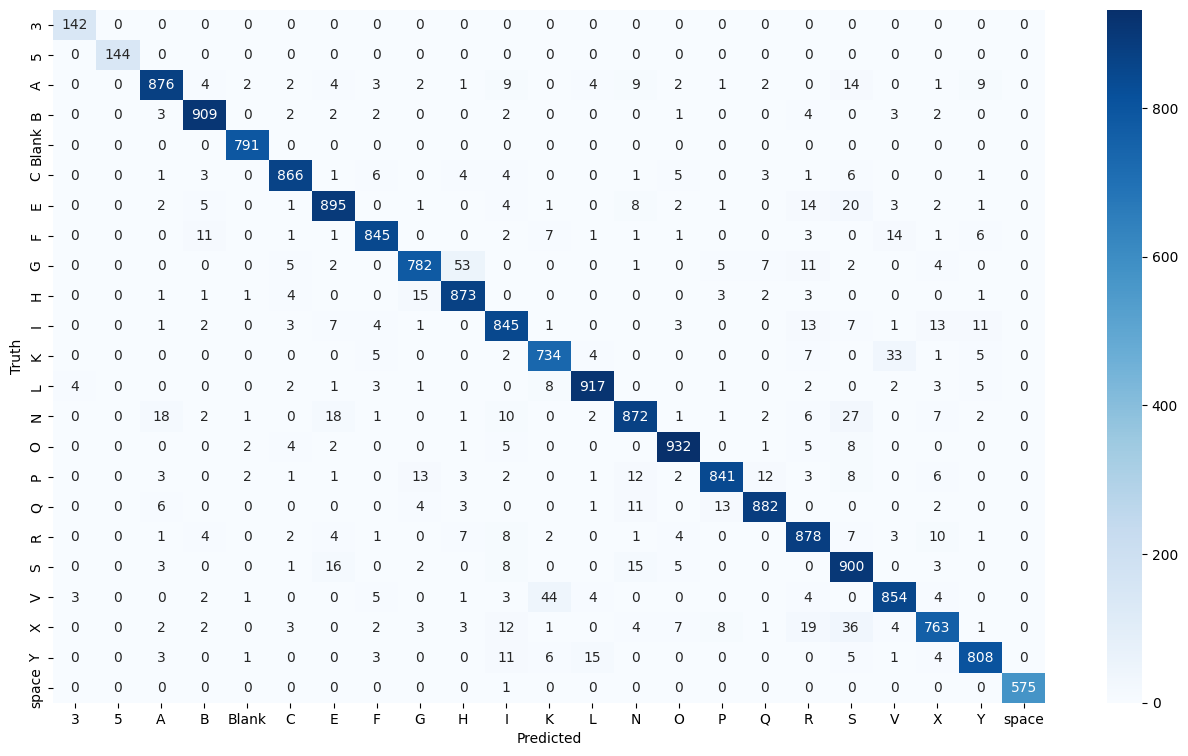

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1 Score for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

# AUC-ROC for each class
lb = LabelBinarizer()
lb.fit(y_true)
y_true_lb = lb.transform(y_true)
y_pred_lb = lb.transform(y_pred)
auc_roc = roc_auc_score(y_true_lb, y_pred_lb, average=None, multi_class='ovr')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Print metrics for each class
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1 Score: {f1[i]}")
    print(f"AUC-ROC: {auc_roc[i]}")
    print()

# Plot confusion matrix as a heatmap
plt.figure(figsize=(16,9))
sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


In [23]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block1b_project_conv
10 block1b_project_bn
11 block1b_project_activation
12 block1b_drop
13 block1b_add
14 block2a_expand_conv
15 block2a_expand_bn
16 block2a_expand_activation
17 block2a_project_conv
18 block2a_project_bn
19 block2b_expand_conv
20 block2b_expand_bn
21 block2b_expand_activation
22 block2b_project_conv
23 block2b_project_bn
24 block2b_drop
25 block2b_add
26 block2c_expand_conv
27 block2c_expand_bn
28 block2c_expand_activation
29 block2c_project_conv
30 block2c_project_bn
31 block2c_drop
32 block2c_add
33 block3a_expand_conv
34 block3a_expand_bn
35 block3a_expand_activation
36 block3a_project_conv
37 block3a_project_bn
38 block3b_expand_conv
39 block3b_expand_bn
40 block3b_expand_activation
41 block3b_project_conv
42 block3b_project_bn
43 block3b_drop
44 block3b_add
45 block3c_expand_conv
46 block3c_expand_bn
47 block3c_

In [22]:
# Cell 9: Unfreeze model and continue training
# for layer in model.layers[-20:]:
#     if not isinstance(layer, layers.BatchNormalization):
#         layer.trainable = True

# # we chose to train the top 2 blocks, i.e. we will freeze
# # the first xxx layers and unfreeze the rest:
# for layer in model.layers[:514]:
#    layer.trainable = False
# for layer in model.layers[514:]:
#    layer.trainable = True
# # we need to recompile the model for these modifications to take effect
# # we train our model again (this time fine-tuning the top 2 blocks
# # alongside the top Dense layers
# optimizer = keras.optimizers.Adam(learning_rate=1e-5)
# model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", metrics=["accuracy","SparseCategoricalAccuracy", "SparseTopKCategoricalAccuracy"])

# epochs = 5
# hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

for layer in model.layers[:410]:
   layer.trainable = False
for layer in model.layers[410:]:
   if not isinstance(layer, layers.BatchNormalization):
      layer.trainable = True

optimizer = keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", metrics=["accuracy","SparseCategoricalAccuracy", "SparseTopKCategoricalAccuracy"])

epochs = 10
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)


Epoch 1/10
4754/4754 [==============================] - 161s 32ms/step - loss: 0.8663 - accuracy: 0.7894 - sparse_categorical_accuracy: 0.7894 - sparse_top_k_categorical_accuracy: 0.9676 - val_loss: 0.4535 - val_accuracy: 0.9422 - val_sparse_categorical_accuracy: 0.9422 - val_sparse_top_k_categorical_accuracy: 0.9938
Epoch 2/10
4754/4754 [==============================] - 153s 32ms/step - loss: 0.8640 - accuracy: 0.7871 - sparse_categorical_accuracy: 0.7871 - sparse_top_k_categorical_accuracy: 0.9678 - val_loss: 0.4528 - val_accuracy: 0.9422 - val_sparse_categorical_accuracy: 0.9422 - val_sparse_top_k_categorical_accuracy: 0.9937
Epoch 3/10
4754/4754 [==============================] - 153s 32ms/step - loss: 0.8628 - accuracy: 0.7900 - sparse_categorical_accuracy: 0.7900 - sparse_top_k_categorical_accuracy: 0.9680 - val_loss: 0.4520 - val_accuracy: 0.9426 - val_sparse_categorical_accuracy: 0.9426 - val_sparse_top_k_categorical_accuracy: 0.9937
Epoch 4/10
4754/4754 [=====================

In [23]:
# import numpy as np

# # Initialize lists to store the true and predicted labels
# y_true = []
# y_pred = []

# # Iterate over the validation dataset
# for images, labels in val_ds:
#     # Get the model's predictions
#     pred_probs = model.predict(images)

#     # Convert the predicted probabilities to class labels
#     preds = np.argmax(pred_probs, axis=1)

#     # Convert one-hot encoded labels back to class labels
#     labels = np.argmax(labels.numpy(), axis=1)

#     # Append the labels to the lists
#     y_true.extend(labels)
#     y_pred.extend(preds)

# # Convert the lists to numpy arrays
# y_true = np.array(y_true)
# y_pred = np.array(y_pred)

#for sparse_categorical_crossentropy
import numpy as np

# Initialize lists to store the true and predicted labels
y_true = []
y_pred = []

# Iterate over the validation dataset
for images, labels in val_ds:
    # Get the model's predictions
    pred_probs = model.predict(images)

    # Convert the predicted probabilities to class labels
    preds = np.argmax(pred_probs, axis=1)

    # Append the labels to the lists
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Convert the lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 [==============================] - 0s 16ms/step


Class: 3
Precision: 0.9726027397260274
Recall: 1.0
F1 Score: 0.9861111111111112
AUC-ROC: 0.9998940228910556

Class: 5
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
AUC-ROC: 1.0

Class: A
Precision: 0.9462943071965628
Recall: 0.9322751322751323
F1 Score: 0.9392324093816631
AUC-ROC: 0.9647539809917364

Class: B
Precision: 0.9701492537313433
Recall: 0.978494623655914
F1 Score: 0.974304068522484
AUC-ROC: 0.9884731468202154

Class: Blank
Precision: 0.986284289276808
Recall: 1.0
F1 Score: 0.9930947897049592
AUC-ROC: 0.9996981836141141

Class: C
Precision: 0.9664804469273743
Recall: 0.958980044345898
F1 Score: 0.9627156371730662
AUC-ROC: 0.9786618419609349

Class: E
Precision: 0.9316062176165804
Recall: 0.9364583333333333
F1 Score: 0.934025974025974
AUC-ROC: 0.9664013168826854

Class: F
Precision: 0.9559322033898305
Recall: 0.9463087248322147
F1 Score: 0.9510961214165261
AUC-ROC: 0.9720782034757101

Class: G
Precision: 0.9434416365824309
Recall: 0.8990825688073395
F1 Score: 0.920728126834997
AUC-R

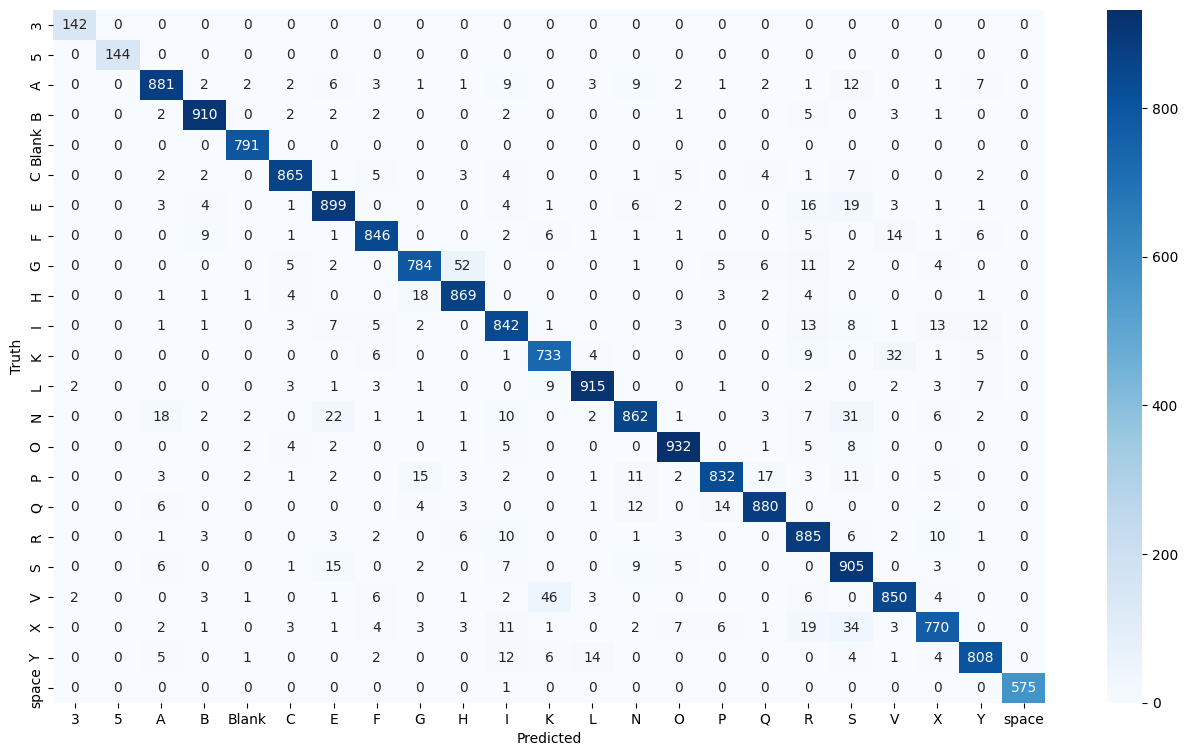

In [24]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from sklearn.metrics import confusion_matrix, roc_auc_score
# from sklearn.preprocessing import LabelBinarizer
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np

# # Accuracy
# accuracy = accuracy_score(y_true, y_pred)

# # Precision, Recall, F1 Score
# average = 'macro'  # or 'micro', 'weighted', depending on the problem
# precision = precision_score(y_true, y_pred, average=average)
# recall = recall_score(y_true, y_pred, average=average)
# f1 = f1_score(y_true, y_pred, average=average)

# # AUC-ROC for multiclass
# lb = LabelBinarizer()
# lb.fit(y_true)
# y_true_lb = lb.transform(y_true)
# y_pred_lb = lb.transform(y_pred)
# auc_roc = roc_auc_score(y_true_lb, y_pred_lb, average=average, multi_class='ovr')

# # Confusion Matrix
# cm = confusion_matrix(y_true, y_pred)

# # Print metrics
# print(f"Accuracy: {accuracy}")
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1 Score: {f1}")
# print(f"AUC-ROC: {auc_roc}")

# #for dataset_alpha
# # class_names = ['Brightness_Decrease', 'Brightness_Increase', 'Chrome_Open', 'Cursor_Movement', 'Double_Click', 'Left_Click', 'Nothing', 'PowerPoint_Open', 'Right_Click', 'Screenshot', 'Scroll', 'Shutdown', 'VSCode_Open', 'Volume_Decrease', 'Volume_Increase']


# # class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

# # class_names = ['A', 'B', 'Blank', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
# # class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
# # class_names = ['A', 'B', 'Blank', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
# #for final_asl_mix
# # class_names = ['A', 'B', 'Blank', 'C', 'E', 'F', 'G', 'H', 'I', 'L', 'N', 'O', 'P', 'Q', 'R', 'S', 'U', 'V', 'W', 'X', 'Y']

# #feb 20 final
# class_names = ['5', 'A', 'B', 'Blank', 'C', 'E', 'F', 'G', 'H', 'I', 'L', 'N', 'O', 'P', 'Q', 'R', 'S', 'V', 'W', 'X', 'Y', 'space']


# # Plot confusion matrix as a heatmap
# plt.figure(figsize=(16,9))
# sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names, cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.show()
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1 Score for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

# AUC-ROC for each class
lb = LabelBinarizer()
lb.fit(y_true)
y_true_lb = lb.transform(y_true)
y_pred_lb = lb.transform(y_pred)
auc_roc = roc_auc_score(y_true_lb, y_pred_lb, average=None, multi_class='ovr')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Print metrics for each class
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1 Score: {f1[i]}")
    print(f"AUC-ROC: {auc_roc[i]}")
    print()

# Plot confusion matrix as a heatmap
plt.figure(figsize=(16,9))
sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()



In [25]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

# Convert the true and predicted labels to a binary matrix
lb = LabelBinarizer()
lb.fit(y_true)
y_true_bin = lb.transform(y_true)
y_pred_bin = lb.transform(y_pred)

# Calculate the macro-averaged AUC-ROC
auc_roc_macro = roc_auc_score(y_true_bin, y_pred_bin, average='macro', multi_class='ovr')
print(f"Macro-Averaged AUC-ROC: {auc_roc_macro}")


Macro-Averaged AUC-ROC: 0.972523635968288


In [26]:
model.save('/home/anon/MajorProject/Non_Git/Models/EfficientNetV2B3_300x300_final_asl_mix_FEB_21_has_3_K_REMOVED_W_batch_size_16_finetuned.h5')

/home/anon/miniconda3/envs/major_tf/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


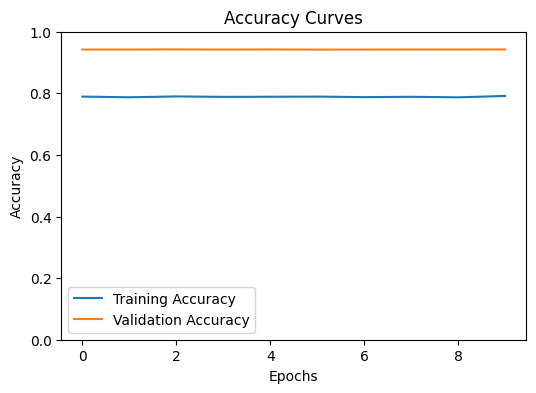

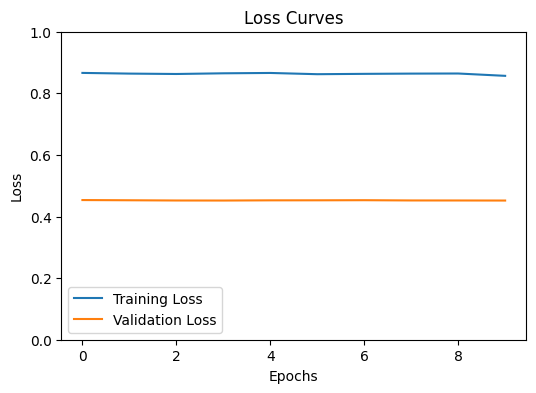

In [27]:
import matplotlib.pyplot as plt

# Plotting the Accuracy Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['accuracy'], linewidth=1.5)
plt.plot(hist.history['val_accuracy'], linewidth=1.5)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()

# Plotting the Loss Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['loss'], linewidth=1.5)
plt.plot(hist.history['val_loss'], linewidth=1.5)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()
